In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from orix.quaternion import Orientation, symmetry
from orix.plot import IPFColorKeyTSL
from orix.vector import Vector3d

import utilities
import pyHREBSD

%matplotlib widget

In [ ]:
ang = "F:/CoNi90/DED_CoNi90.ang"
up2 = "F:/CoNi90/DED_CoNi90.up2"
name = "CoNi90-DED"
pixel_size = 13.0
sample_tilt = 68.0  # The sample tilt in degrees
detector_tilt = 10.3  # The detector tilt in degrees

# Pattern processing
truncate = True
sigma = 15
equalize = True

# Initial guess
initial_subset_size = 1024  # The size of the subset, must be a power of 2
guess_type = "full"  # The type of initial guess to use, "full", "partial", or "none"

# Subpixel registration
h_center = "image"  # The homography center for deformation, "pattern" or "image"
max_iter = 100  # The maximum number of iterations for the subpixel registration
conv_tol = 1e-3  # The convergence tolerance for the subpixel registration
subset_shape = "rectangle"  # The shape of the subset for the subpixel registration, "rectangle", "ellipse", or "donut"
subset_size = (900, 900) # The size of the subset for the subpixel registration, (H, W) for "rectangle", (a, b) for "ellipse", or (r_in, r_out) for "donut"

# Read in data
pat_obj, ang_data = utilities.get_scan_data(up2, ang)

# Set the homography center properly
if h_center == "pattern":
    PC = ang_data.pc
elif h_center == "image":
    PC = (pat_obj.patshape[1] / 2, pat_obj.patshape[0] / 2, ang_data.pc[2])

point = (517, 321)
size = 8
idx = utilities.get_index(point, size, ang_data)

# Get patterns
pats = utilities.get_patterns(pat_obj, idx=idx).astype(float)
# sharpness = utilities.get_sharpness(pats)
pats = utilities.process_patterns(pats, sigma=sigma, equalize=False, truncate=truncate, batch_size=4)

# x, y = point
# x0, x1 = max(x - size // 2, 0), min(x + size // 2, ang_data.shape[0])
# y0, y1 = max(y - size // 2, 0), min(y + size // 2, ang_data.shape[1])
# slc = (slice(x0, x1), slice(y0, y1))
# ori = Orientation(ang_data.quats[slc], symmetry.Oh)
# ipfkey100 = IPFColorKeyTSL(symmetry.Oh, Vector3d((1, 0, 0)))
# ipf100 = ipfkey100.orientation2color(ori)
# img = utilities.shade_ipf(ipf100, sharpness)

# Reference index
x0 = (4, 4)  # The index of the reference pattern

plt.close('all')
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(pats[x0], cmap="gray")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01)
plt.show()

In [ ]:
R = pats[x0]
T = pats
tilt = 90 - sample_tilt + detector_tilt
p0 = pyHREBSD.get_initial_guess(R, T, PC, tilt, initial_subset_size, guess_type)

# Get homographies
subset_slice = (slice(int(PC[1] - subset_size[0] / 2), int(PC[1] + subset_size[0] / 2)),
                slice(int(PC[0] - subset_size[1] / 2), int(PC[0] + subset_size[1] / 2)))
print("Getting homographies...")
p, i_count, residuals, norms = pyHREBSD.get_homography(
    R,
    T,
    subset_slice=subset_slice,
    p0=p0,
    PC=PC,
    max_iter=max_iter,
    conv_tol=conv_tol,
    parallel_cores=12,
)
np.save(f"{name}_p.npy", p)
np.save(f"{name}_i_count.npy", i_count)
np.save(f"{name}_residuals.npy", residuals)
np.save(f"{name}_norms.npy", norms)

In [ ]:
i_count = np.load(f"{name}_i_count.npy")
residuals = np.load(f"{name}_residuals.npy")
norms = np.load(f"{name}_norms.npy")

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
im0 = ax[0].imshow(i_count, cmap="viridis")
ax[0].set_title("Iteration count")
im1 = ax[1].imshow(residuals, cmap="viridis")
ax[1].set_title("Residuals")
im2 = ax[2].imshow(norms, cmap="viridis")
ax[2].set_title("Norms")
plt.subplots_adjust(wspace=0.5, left=0.01, right=0.9, top=0.99, bottom=0.01)

l = ax[0].get_position()
cax = fig.add_axes([l.x1 + 0.01, l.y0, 0.02, l.height])
plt.colorbar(im0, cax=cax)
l = ax[1].get_position()
cax = fig.add_axes([l.x1 + 0.01, l.y0, 0.02, l.height])
plt.colorbar(im1, cax=cax)
l = ax[2].get_position()
cax = fig.add_axes([l.x1 + 0.01, l.y0, 0.02, l.height])
plt.colorbar(im2, cax=cax)

plt.show()

In [ ]:
p = np.load(f"{name}_p.npy")
PC_mod = (ang_data.pc[0] - 512, ang_data.pc[1] - 512, PC[2])
Fe = pyHREBSD.homography_to_elastic_deformation(p, PC_mod)
# C = utilities.get_stiffness_tensor(165.6, 63.9, 79.5, structure="cubic")
# e, w, s = pyHREBSD.deformation_to_stress_strain(Fe, C, small_strain=False)
e, w = pyHREBSD.deformation_to_stress_strain(Fe, small_strain=False)

plt.close('all')
utilities.view_tensor_images(Fe, tensor_type="deformation", xy=x0, save_name=name, save_dir="results/")
utilities.view_tensor_images(e, tensor_type="strain", xy=x0, save_name=name, save_dir="results/", show="upper")
utilities.view_tensor_images(w, tensor_type="rotation", xy=x0, save_name=name, save_dir="results/", show="upper")

u = np.array([w[..., 2, 1] - w[..., 1, 2], w[..., 0, 2] - w[..., 2, 0], w[..., 1, 0] - w[..., 0, 1]])
mask = u[2] < 0
theta = np.arcsin(np.linalg.norm(u, axis=0) / 2) * 180 / np.pi
theta[mask] *= -1
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
im = ax.imshow(theta, cmap="viridis")
plt.colorbar(im, ax=ax)
plt.show()

In [ ]:
import os
import struct
import shutil

up2 = "E:/GaN/GaN_2048x2048_alt.up2"
# up2 = "E:/GaN/GaN.up2"

with open(up2, "rb") as upFile:
    try:
        upFile = open(up2, "rb")
        chunk_size = 4
        tmp = upFile.read(chunk_size)
        FirstEntryUpFile = struct.unpack("i", tmp)[0]
        tmp = upFile.read(chunk_size)
        sz1 = struct.unpack("i", tmp)[0]
        tmp = upFile.read(chunk_size)
        sz2 = struct.unpack("i", tmp)[0]
        tmp = upFile.read(chunk_size)
        bitsPerPixel = struct.unpack("i", tmp)[0]
        sizeBytes = os.path.getsize(up2) - 16
        sizeString = str(round(sizeBytes / 1e6, 1)) + " MB"
        bytesPerPixel = 2
        nPatternsRecorded = int((sizeBytes / bytesPerPixel) / (sz1 * sz2))
    except Exception as e:
        print("Error reading the .up2 file:", e)

print(f"FirstEntryUpFile: {FirstEntryUpFile}")
print(f"sz1: {sz1}")
print(f"sz2: {sz2}")
print(f"bitsPerPixel: {bitsPerPixel}")
print(f"sizeBytes: {sizeString}")
print(f"nPatternsRecorded: {nPatternsRecorded}")


sz1 = 2048
sz2 = 2048

filename = "E:/GaN/GaN_2048x2048_alt.up2"
upFile_write = open(filename, "wb")
upFile_read = open(up2, "rb")
try:
    upFile_read.seek(16)

    # Write the header
    upFile_write.write(struct.pack('i', 1))
    upFile_write.write(struct.pack('i', sz1))
    upFile_write.write(struct.pack('i', sz2))
    upFile_write.write(struct.pack('i', 16))


    shutil.copyfileobj(upFile_read, upFile_write)
    upFile_read.close()
    upFile_write.close()
except Exception as e:
    print("Error writing the .up2 file:", e)
    upFile_read.close()
    upFile_write.close()

[0 0 0] [0 0 0]


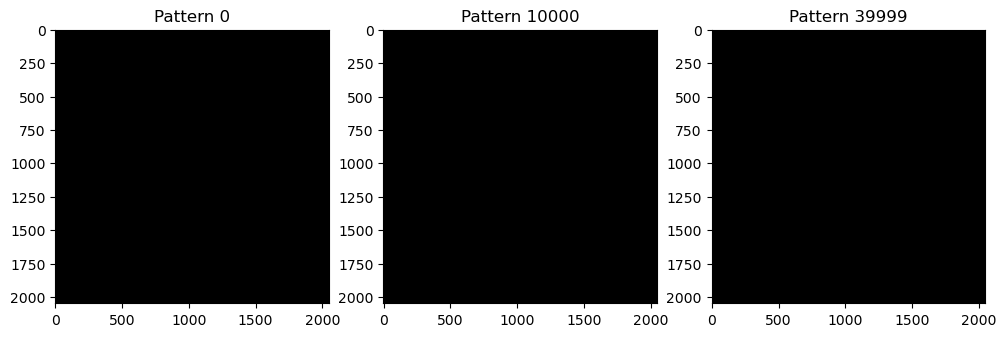

In [9]:
import utilities
import matplotlib.pyplot as plt

up2 = "E:/GaN/GaN_2048x2048_alt.up2"
pat_obj = utilities.read_up2(up2)
pats = utilities.get_patterns(pat_obj, [0, 10000, 39999])

print(pats.min(axis=(1, 2)), pats.max(axis=(1, 2)))
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(pats[0], cmap="gray")
ax[0].set_title("Pattern 0")
ax[1].imshow(pats[1], cmap="gray")
ax[1].set_title("Pattern 10000")
ax[2].imshow(pats[2], cmap="gray")
ax[2].set_title("Pattern 39999")
plt.show()